# Week 3 Activity: Synthesis Functions

Complete this activity as part of your participation grade. Pending length of the lecture, you will have time in class to work. Everything you need to complete this activity can be found in this week's (or a previous week's) lecture code. For this activity, you may want to consult your Audio Tech I notes (or the Computer Music Tutorial)

In [112]:
import numpy as np
from scipy.io.wavfile import read
from IPython.display import Audio
import matplotlib.pyplot as plt
from scipy.signal import sawtooth, square

## 1. Create an envelope function

Write a function called adsr() that will modify a passed sound according to an ADSR envelope that is user-defined. 
Your function should include the following arguments at a minimum:

1) a: Time to reach maximum amplitude (can be zero to length of input). (float)

2) s: The level (amplitude) of the sustain portion. (float)

3) d: Time to descend from max to sustain level (N.B. time can be zero, and sustain can be False.) (float)

4) r: Time to descend to zero (N.B. should be a minimum of 20ms). (float)

5) x: array of samples of length n that will be modulated by the envelope. (np.array)

Your function should return the input sound modified by the envelope

**Notes**

Optimizing your function:  The following are things to consider, but not necessary as a "first step":  

* Your function ideally should allow for all scenarios including passing sound arrays of various lengths, and, it should allow for a sharp attack followed by an immediate decay with zero sustain (like a plucked or percussive sound) regardless of the total length of the sound passed. I.e., If there is no sustain value, then the Decay (#3) and Sustain (#2) are moot, so your function should just ascend to peak value over some time, x, and then descend to zero over time x.

* Be sure to include default values to all your arguments (except #5)

* You will need to define additional defaults within the function such as the sample rate. (You may want to make this an argument variable with a default value).


Heads up: This will likely be the most tedious question of this activity as it is a lot of array manipulation and edge case finding. 

Note: depending on your implementation, the following functions may come in handy:

`np.max` returns the maximum value in an array  
`np.min` returns the minimum value in an array  
`np.size` returns the total length of an array   
`np.where` returns index value(s) matching boolean conditions  
`np.zeros(n)` returns an array of zeros of length n  
`np.ones(n)` returns an array of ones of length n  
`np.full(n, val)` returns an array of values (val) of length n  

In [119]:
# There are a lot of different ways to implement this. This is just one solution.

# As to not perfectly match Project 1, this assumes attack, decay, release are passed as millisecond values and sustain is from 0-1. It also assumes peak amplitude should be 1 for the envelope.

def adsr(x, attack, decay, sustain, release, fs=44100):
    size_ms = len(x) / fs * 1000
    # I'm converting to percents. You don't need to and its creating extra work in the function, but it may be useful to you later for Project 1
    attack_percent = attack / size_ms
    decay_percent = decay / size_ms
    release_percent = release / size_ms

    if sustain is False:
        # this turns the envelope into an attack-release only. I just ignore the decay if sustain is not set
        attack_samples = int(attack_percent * len(x))
        release_samples = int(release_percent * len(x))
        if attack_samples + release_samples > len(x):
            print("Attack and release values are longer than audio segment. Please pass in values smaller than total input length of " + str(size_ms) + " ms.")
            return x
        pad = np.zeros(len(x) - (attack_samples + release_samples))

        attack_section = np.linspace(0, 1, attack_samples)
        release_section = np.linspace(1, 0, release_samples)

        env = np.concatenate([attack_section, release_section, pad])
        return x * env

    else:
        attack_samples = int(attack_percent * len(x))
        decay_samples = int(decay_percent * len(x))
        release_samples = int(release_percent * len(x))
        if attack_samples + decay_samples + release_samples > len(x):
            print("Attack, decay, and release values are longer than audio segment. Please pass in values smaller than total input length of " + str(size_ms) + " ms.")
            return x

        sustain_samples = len(x) - (attack_samples + decay_samples + release_samples)

        attack_section = np.linspace(0, 1, attack_samples)
        decay_section = np.linspace(1, sustain, decay_samples)
        sustain_section = np.full(sustain_samples, sustain)
        release_section = np.linspace(sustain, 0, release_samples)

        env = np.concatenate([attack_section, decay_section, sustain_section, release_section])
        return x * env


In [120]:
# some tests to try

# even array
x = np.ones(44100)
out = adsr(x, 400, 100, 0.8, 400)

# odd array
x = np.ones(44101)
out = adsr(x, 400, 100, 0.8, 400)

# zero values
x = np.ones(44101)
out = adsr(x, 0, 100, 0.8, 400)

# zero values
x = np.ones(44101)
out = adsr(x, 0, 0, 0.8, 0)

# no sustain values
x = np.ones(44101)
out = adsr(x, 20, 0, 0, 900)

# false sustain values
x = np.ones(44101)
out = adsr(x, 20, 20, False, 900)

# values greater than the input audio
x = np.ones(44101)
out = adsr(x, 900, 0, 0, 900)

Attack, decay, and release values are longer than audio segment. Please pass in values smaller than total input length of 1000.0226757369614 ms.


## 2. Create an amplitude modulation function

1. Write a function called amp_mod() for amplitude modulation. Your function should have the following arguments at minimum.

* carrier input signal (np.array)
* sampling rate (float)
* frequency of modulator (float)
* wave shape of the modulator (string: 'sine', 'square', 'tri', 'saw')
* boolean for polarity - should it be bipolar (True or False)

You need sampling rate to determine the proper relationship to length of the array and frequency.

Note: 
* modulator wave_shape --> should be sinusoid, square, sawtooth, or triangle (you may use `scipy.signal` library to make it easier - see: https://docs.scipy.org/doc/scipy/reference/signal.html and scroll to "Waveforms")  
* time --> the time or length of the carrier signal (modulator should exactly match)


In [78]:
def amp_mod(x, mod_freq, mod_type, depth=0.5, ring=False, fs=44100):
    x_sec = len(x) / fs

    time_arr = np.arange(0, x_sec, 1/fs)
    if mod_type.casefold() == 'sine':
        mod = np.sin(np.pi*2 * mod_freq * time_arr)
    elif mod_type.casefold() == 'square':
        mod = square(2*np.pi * mod_freq * time_arr)
    elif mod_type.casefold() == 'saw':
        mod = saw(2*np.pi * mod_freq * time_arr)
    elif mod_type.casefold() == 'tri':
        mod = saw(2*np.pi * mod_freq * time_arr, width=0.5)
    else:
        print('Please enter sine, square, saw, or tri for modulator wave type')
        return None
    
    if not ring:
        mod += 1
    
    return x * (depth*mod)


2. Apply your function to the following scenarios.

a) Apply ring modulation with a square wave with a mod frequency of 50 Hz to a loaded audio file

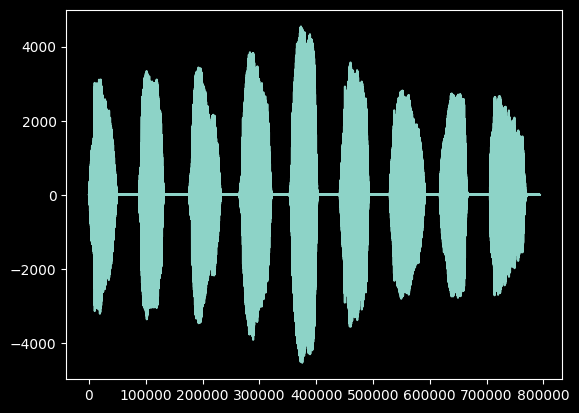

In [79]:
fs, x = read('/Users/jocelynkavanagh/Documents/Code/MUSI2626/AudioTechII-Live/audio/femaleSingingScale.wav')

out = amp_mod(x, 50, 'square', 0.5, ring=True, fs=fs)
plt.plot(out)
Audio(out, rate=fs)

b) Apply amplitude modulation with a sine wave to a 200 Hz sine wave with an arbitrary modulator frequency. Plot the magnitude spectrum.

(0.0, 400.0)

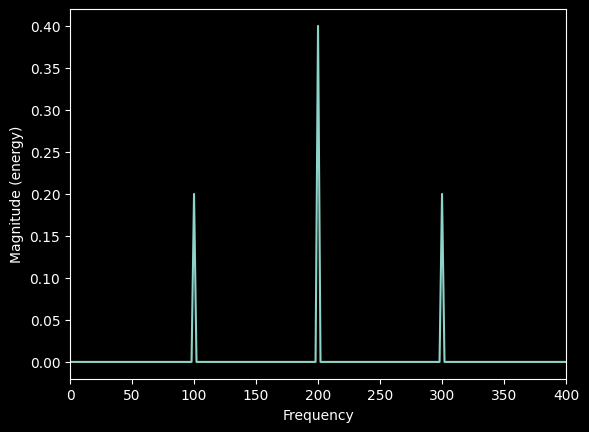

In [80]:
x = np.sin(2*np.pi * 200 * np.arange(0, 1, 1/44100))
out = amp_mod(x, 100, 'sine', 0.8)
plt.magnitude_spectrum(out, Fs=fs)
plt.xlim([0,400])

c) Apply ring modulation with a sine wave to a 200 Hz sine wave with a modulator frequency such that the output is inharmonic. Plot the magnitude spectrum.

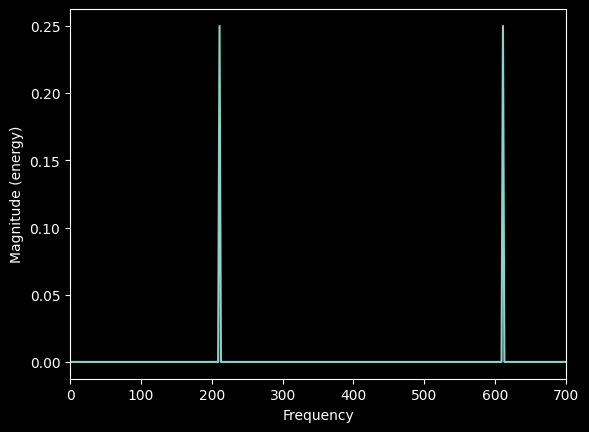

In [ ]:
x = np.sin(2*np.pi * 200 * np.arange(0, 1, 1/44100))
out = amp_mod(x, 411, 'sine', 1, ring=True)
plt.magnitude_spectrum(out, Fs=fs)
plt.xlim([0,700])
Audio(out, rate=fs)

# sidebands at 211 and 611 which are not integer related

d) Apply ring modulation with a sine wave to a 200 Hz sine wave with a modulator frequency such that the output only seems to have 1 frequency component. Plot the magnitude spectrum.

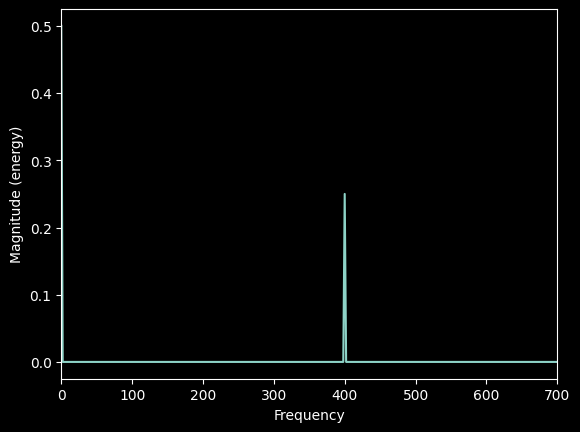

In [ ]:
x = np.sin(2*np.pi * 200 * np.arange(0, 1, 1/44100))
out = amp_mod(x, 200, 'sine', 1, ring=True)
plt.magnitude_spectrum(out, Fs=fs)
plt.xlim([0,700])
Audio(out, rate=fs)

# sidebands at 0 and 400

## 3. Create an FM synthesis function 

1. Create a function called fmSynth() for FM synthesis (or more aptly PM synthesis). Your function should include the following arguments.

* Depth of modulation *or* modulation index (float) 
* Carrier frequency (float)
* Modulator frequency (float)
* time in seconds (float)

Your function should return a np.array with the synthesized sound

In [90]:
def fmSynth(carrier_freq, mod_freq, index, dur, fs=44100):
    time_arr = np.arange(0, dur, 1/fs)
    modulator = np.sin(2*np.pi * mod_freq * time_arr)

    return np.sin((2*np.pi * carrier_freq * time_arr) + (index * modulator))


2) Using your function, try to create the following types of sounds. Try to understand the relation between the modulator and carrier in contributing to harmonic versus inharmonic sounds.

a) Inharmonic   

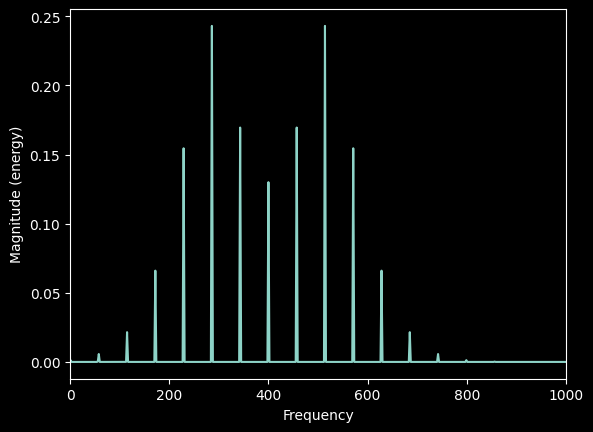

In [94]:
out = fmSynth(400, 57, 3, 1)
plt.magnitude_spectrum(out, Fs=fs)
plt.xlim([0, 1000])
Audio(out, rate=fs)

 b) harmonic where the carrier is the fundamental  


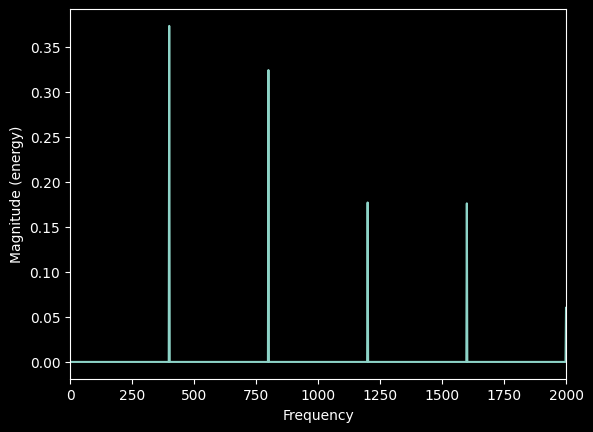

In [110]:

carrier = 400
out = fmSynth(carrier, carrier, 3, 1)
plt.magnitude_spectrum(out, Fs=fs)
plt.xlim([0, 2000])
Audio(out, rate=fs)

c) harmonic where the carrier is not the fundamental.  

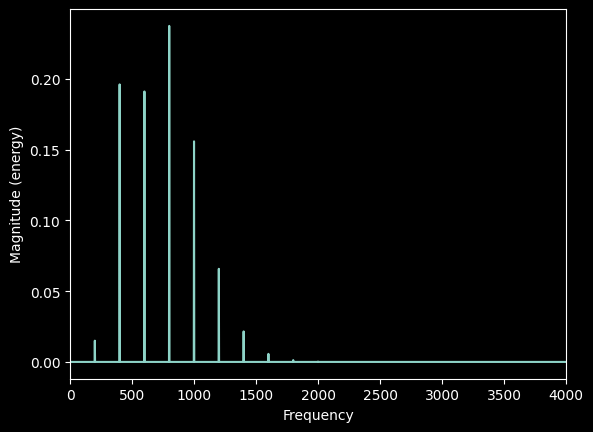

In [111]:
carrier = 400
out = fmSynth(400, carrier/2, 3, 1)
plt.magnitude_spectrum(out, Fs=fs)
plt.xlim([0, 4000])
Audio(out, rate=fs)